## Detrending Tutorial

First we detrend with a Savitzky-Golay filter: 

In [1]:
import pens
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use('default')
pens.set_style()

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'LMR v2.1'}, xlabel='Year (CE)', ylabel='GMST [K]'>)

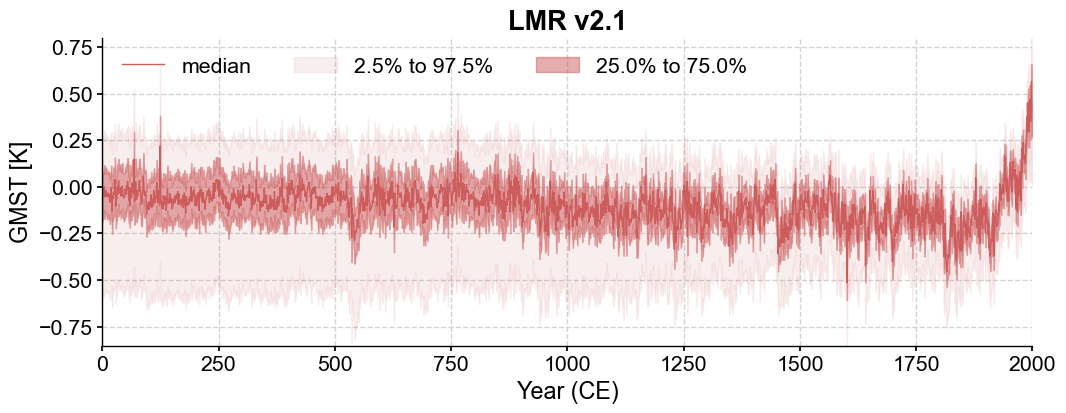

In [6]:
path = '../data/gmt_MCruns_ensemble_full_LMRv2.1.nc'
ens_LMR = pens.EnsembleTS().load_nc(path, var='gmt')
ens_LMR.label = 'LMR v2.1'
ens_LMR.plot_qs(ylabel='GMST [K]')

Text(0.5, 0.98, 'Detrending via Savitzky-Golay')

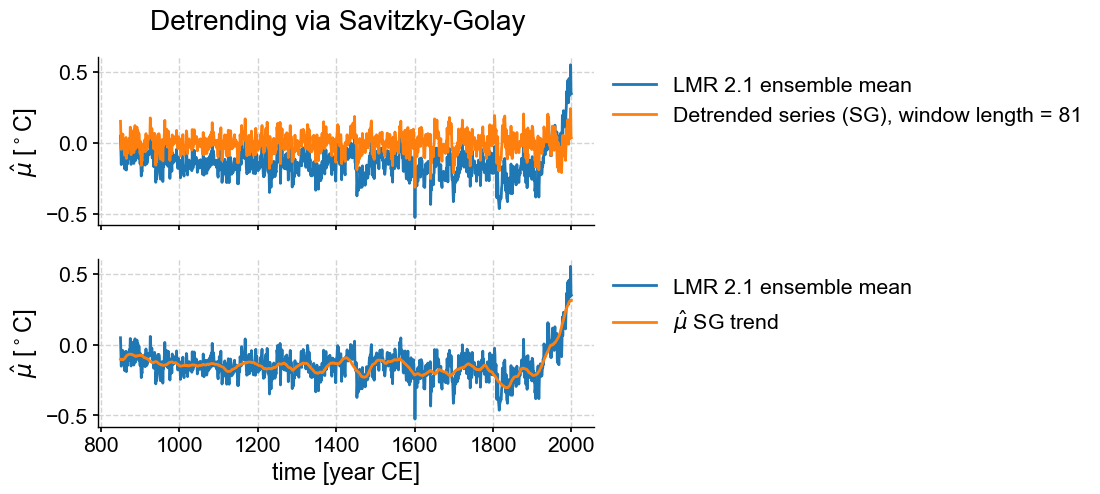

In [35]:
mu_ts = pyleo.Series(time=lmr_slice.time, time_unit="year CE", label = 'LMR 2.1 ensemble mean',
                     value=mu, value_name=r'$\hat{\mu}$', value_unit=r'${}^\circ$C')

win = 81
mu_dtd = mu_ts.detrend(method='savitzky-golay',sg_kwargs={'window_length': win}, keep_log=True)
mu_dtd.label = 'Detrended series (SG), window length = ' + str(win)
mu_trend = mu_ts.copy()
mu_trend.value = mu_dtd.log[1]['previous_trend']
mu_trend.label = r'$\hat{\mu}$ SG trend'

fig, axs = plt.subplots(2,1,sharex=True)
# top 
mu_ts.plot(ax=axs[0])
mu_dtd.plot(ax=axs[0],lgd_kwargs={'bbox_to_anchor': (1, 1)})
axs[0].set_xlabel(None)
# bottom
mu_ts.plot(ax=axs[1])
mu_trend.plot(ax=axs[1],lgd_kwargs={'bbox_to_anchor': (1, 1)})
fig.suptitle('Detrending via Savitzky-Golay')

### Digression : detrending methods

There are two other ways to remove a trend while keeping track of what was done in pyleoclim: Empirical Mode Decomposition and Singular Spectrum Analysys

Text(0.5, 0.98, 'Detrending via EMD')

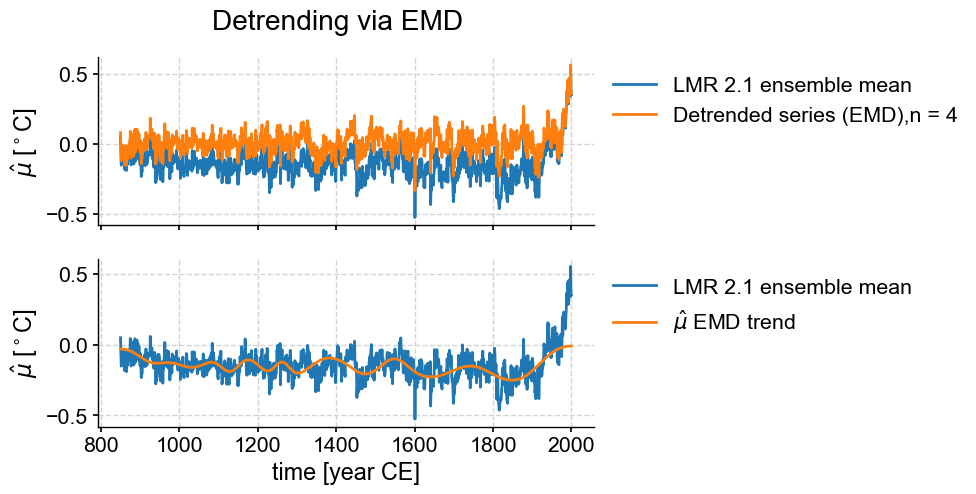

In [46]:
nmodes = 4
mu_emd = mu_ts.detrend(method='emd',n=nmodes, keep_log=True)
mu_emd.label = 'Detrended series (EMD),n = ' + str(nmodes)
mu_emd_trend = mu_ts.copy()
mu_emd_trend.value = mu_emd.log[1]['previous_trend']
mu_emd_trend.label = r'$\hat{\mu}$ EMD trend'

fig, axs = plt.subplots(2,1,sharex=True)
# top 
mu_ts.plot(ax=axs[0])
mu_emd.plot(ax=axs[0],lgd_kwargs={'bbox_to_anchor': (1, 1)})
axs[0].set_xlabel(None)
# bottom
mu_ts.plot(ax=axs[1])
mu_emd_trend.plot(ax=axs[1],lgd_kwargs={'bbox_to_anchor': (1, 1)})
fig.suptitle('Detrending via EMD')

No good! Let's see what SSA can do. One expect such a trend to show up as the first mode.

In [48]:
ssa = mu_ts.ssa()

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

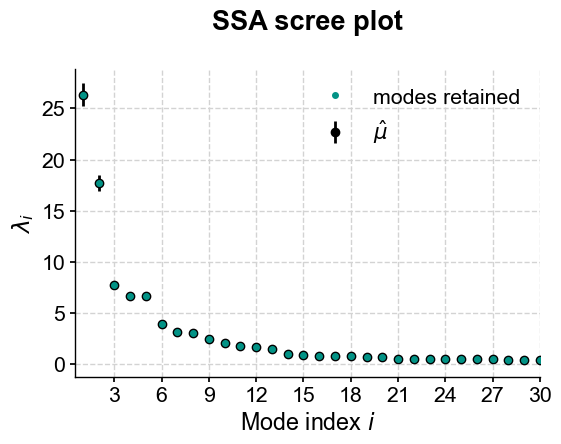

In [52]:
ssa.screeplot(xlim=[0, 30])

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectrum (mtm)'}, xlabel='Period', ylabel='PSD'>)

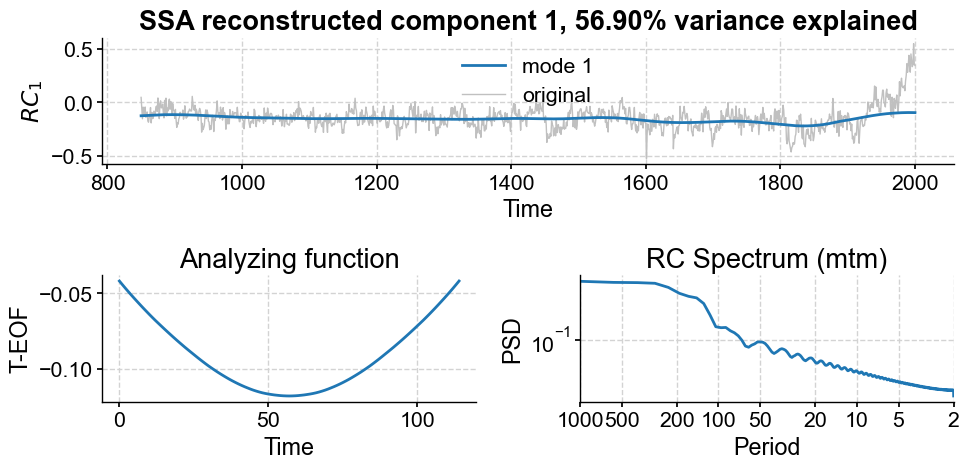

In [53]:
ssa.modeplot()

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectrum (mtm)'}, xlabel='Period', ylabel='PSD'>)

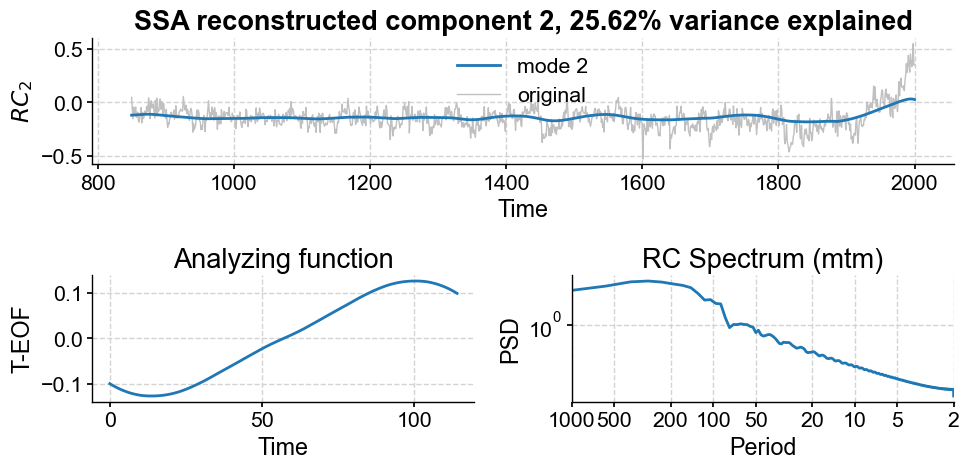

In [54]:
ssa.modeplot(index=1)

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectrum (mtm)'}, xlabel='Period', ylabel='PSD'>)

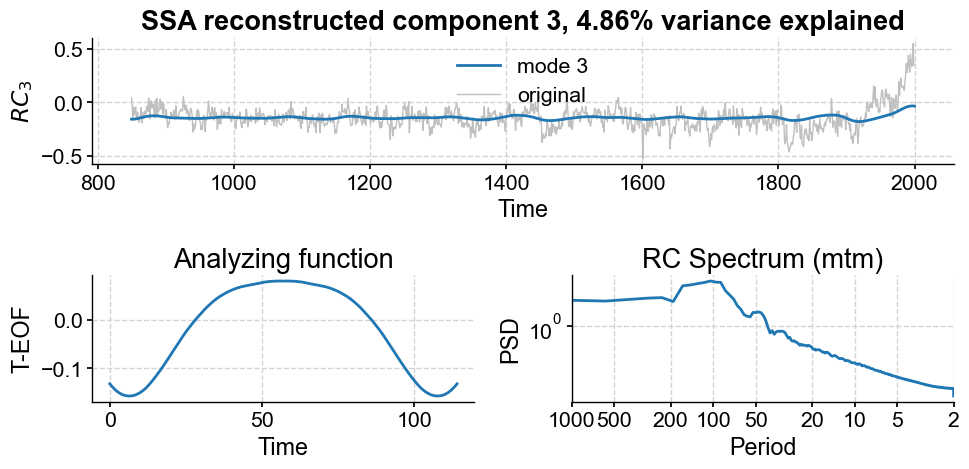

In [55]:
ssa.modeplot(index=2)

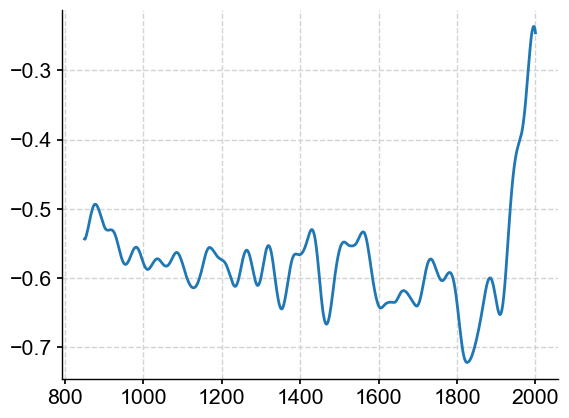

In [58]:
RC3 = ssa.RCmat[:,:4].sum(axis=1)
plt.plot(mu_ts.time,RC3)

No clean identification of the trend with SSA (it's a first for me!). Let's try good old-fashioned Lanczos filtering instead:

<AxesSubplot:xlabel='time [year CE]', ylabel='$\\hat{\\mu}$ [${}^\\circ$C]'>

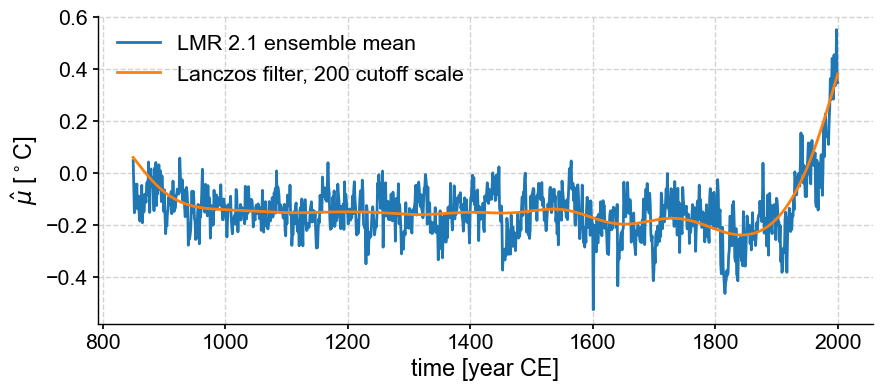

In [72]:
cut = 200
mu_lanc = mu_ts.filter(method='lanczos',cutoff_scale=cut)
mu_lanc.label = 'Lanczos filter, '+str(cut)+ ' cutoff scale' 
fig, ax = mu_ts.plot()
mu_lanc.plot(ax=ax)

Better, but some annoying edge effect at the start. Let's use the full series to do this instead:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='time [year CE]', ylabel='$\\hat{\\mu}$ [${}^\\circ$C]'>)

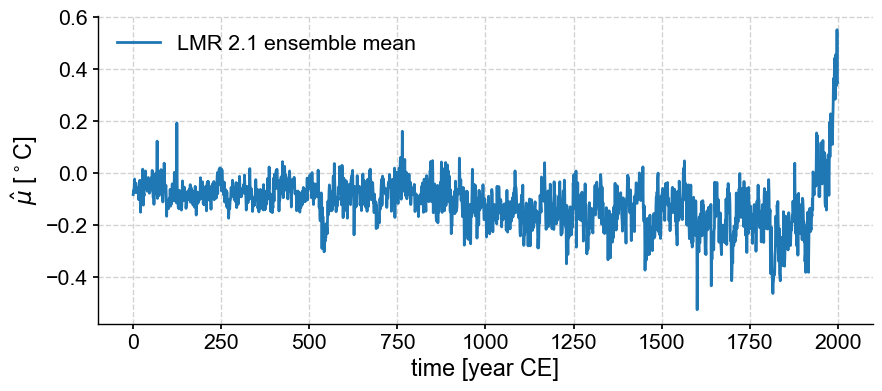

In [69]:
mu2k = mu_ts.copy()
mu2k.time= ens_LMR.time
mu2k.value = ens_LMR.value.mean(axis=1)
mu2k.plot()

<AxesSubplot:xlabel='time [year CE]', ylabel='$\\hat{\\mu}$ [${}^\\circ$C]'>

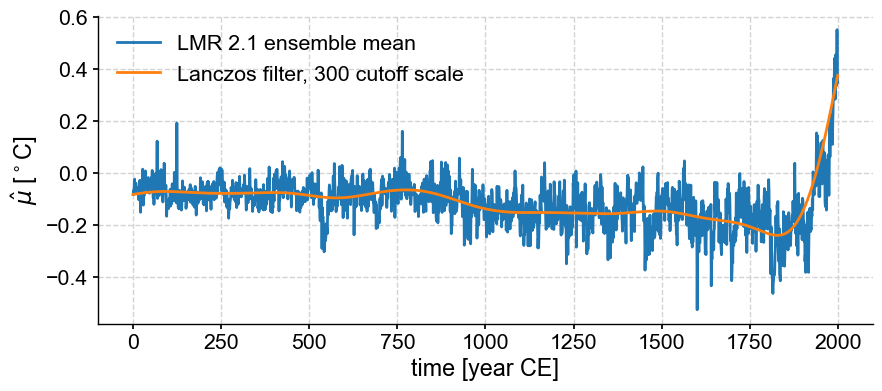

In [75]:
cut=300
mu_lanc = mu2k.filter(method='lanczos',cutoff_scale=cut)
mu_lanc.label = 'Lanczos filter, '+str(cut)+ ' cutoff scale' 
fig, ax = mu2k.plot()
mu_lanc.plot(ax=ax)

Text(0.5, 0.98, 'Detrending via Lanczos filter')

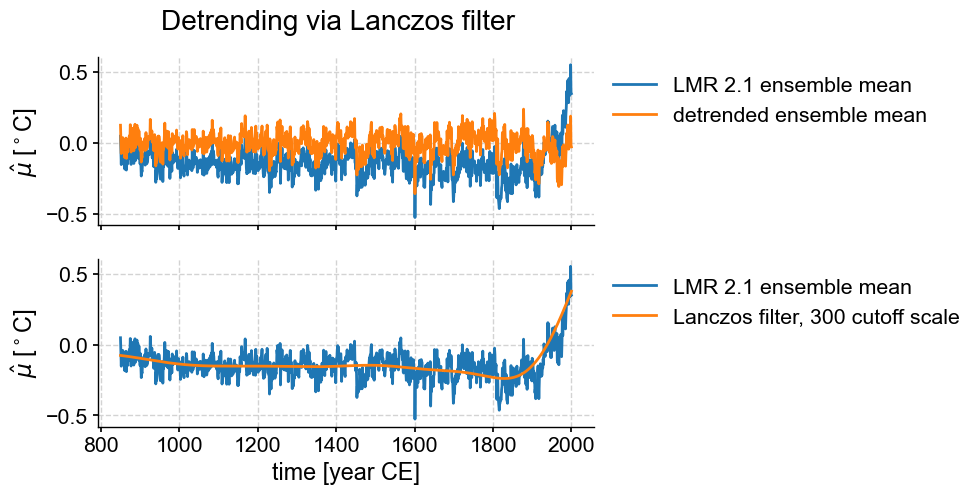

In [81]:
mu_dtd = mu_ts.copy()
time_bnds = [mu_ts.time.min(), mu_ts.time.max()]
mu_trend = mu_lanc.slice(time_bnds)
mu_dtd.value = mu_ts.value-mu_trend.value
mu_dtd.label = 'detrended ensemble mean'

# plot it 
fig, axs = plt.subplots(2,1,sharex=True)
mu_ts.plot(ax=axs[0])
mu_dtd.plot(ax=axs[0],lgd_kwargs={'bbox_to_anchor': (1, 1)})
axs[0].set_xlabel(None)
mu_ts.plot(ax=axs[1])
mu_trend.plot(ax=axs[1],lgd_kwargs={'bbox_to_anchor': (1, 1)})
fig.suptitle('Detrending via Lanczos filter')